# FWI Example
We will peform FWI using the following steps:
1. [Prepare models](#models)
    * Read the true model from binary file
    * Generate our subsampled true and initial models
2. [Setup Constraints](#constraints) with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl)
    * Setup
    * Illustrate constraints on a noisy model
3. [Build a small local compute cluster (2 workers)](#cluster)
    * Take care of some HPC details related to thread affinity
4. [Create list of shot locations](#pos)
5. [Build `F`, the distributed block operator for seismic modeling](#buildF)
6. [Use `F` to create data for both models](#data)
7. [Visualize data](#vizD)
8. [Assess if data is cycle skipped at the farthest offsets](#cskiped)
9. [Build the `objective` function](#objective)
10. [Perform the FWI using `minConf_PQN`](#inversion) from [JUDI](https://github.com/slimgroup/JUDI.jl)
11. [Visualize velocity models and objective function](#plotres)
12. [Visualize data match](#matchD)
13. [Write models to local disk](#writeres)
14. [Remove local files and workers](#del)

#### Note on runtime
Warning: this notebook takes more than 1 hour to run for 16 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

In [1]:
# Activate environment with all required packages
using DrWatson
@quickactivate "ConstrainedFWIExamples"
import Pkg; Pkg.instantiate()

## Record time for start of notebook

In [2]:
time_beg = time()

1.603844455769671e9

In [3]:
using PyPlot, Distributed, Jets, JetPack, JetPackDSP, Printf
using LinearAlgebra, JUDI.SLIM_optim, SetIntersectionProjection, FFTW

## 1. Prepare models <a id='models'></a>

#### Read true model from binary file

In [4]:
base_path =  projectdir()*"/data/"
v = read!(base_path*"marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));

#### Subsample models
We are running a low frequency FWI, so we resample the model from a 20m grid to a 40m grid so that the modeling will run faster.

In [5]:
v = v[1:2:end,1:2:end]

dz,dx = 40.0,40.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (40.0, 40.0)
(nz, nx) = (88, 426)


#### Smooth the true model to generate true and initial models
Note that we will perform this FWI example at low frequency, and so we smooth both the true and the initial models before we begin. 

Please refer to the smoothing notebook in the `20_marmousi_model_setup` example directory for more details on our smoothing approach. Note that we apply the smoothing in slowness to preserve traveltime.

In [6]:
# smoothing for the true model
ns1 = 1
P1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=true)
S1 = JopConvolve(range(P1), smoother=:rect, n=(ns1,ns1))
R1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=false)
s1 = R1' ∘ S1 ∘ P1 * (1 ./ v)
v1 = 1 ./(s1);

# smoothing for the initial model
ns2 = 5
P2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=true)
S2 = JopConvolve(range(P2), smoother=:rect, n=(ns2,ns2))
R2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=false)
s2 = R2' ∘ S2 ∘ P2 * (1 ./ v)
v2 = 1 ./(s2);

#### Replace the water layer in both models

In [7]:
v1[v.==1500.0] .= 1500.0;
v2[v.==1500.0] .= 1500.0;

#### Visualize

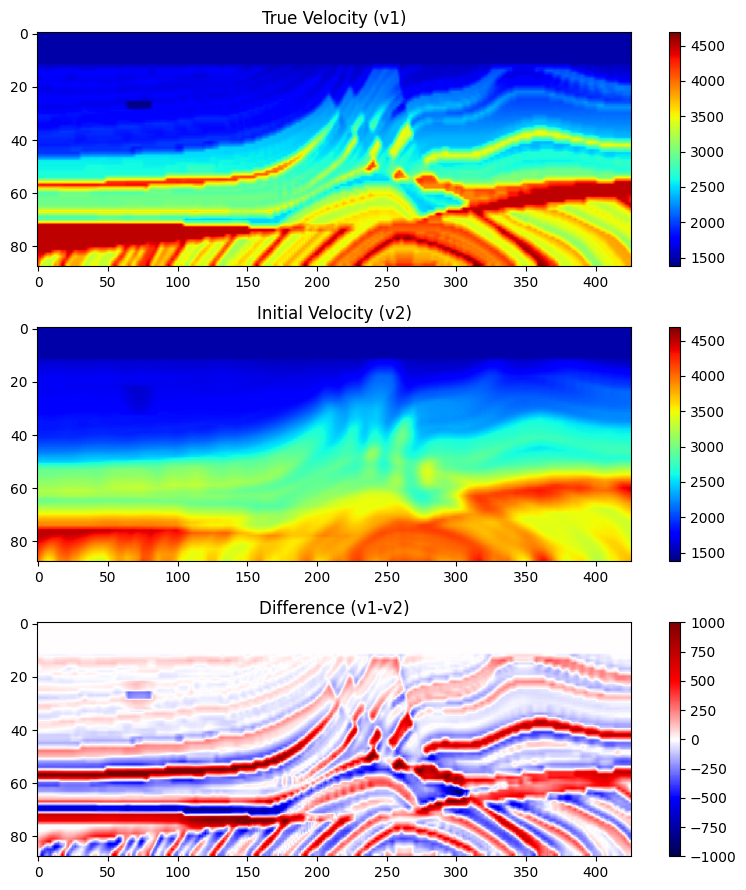

In [8]:
figure(figsize=(8,9))
vmin,vmax = extrema(v1)
dmin,dmax = -1000,1000

subplot(3,1,1); imshow(v1,aspect="auto",cmap="jet"); 
colorbar(); clim(vmin,vmax); title("True Velocity (v1)")

subplot(3,1,2); imshow(v2,aspect="auto",cmap="jet");
colorbar(); clim(vmin,vmax); title("Initial Velocity (v2)");

subplot(3,1,3); imshow(v1.-v2,aspect="auto",cmap="seismic");
colorbar(); clim(dmin,dmax); title("Difference (v1-v2)");

tight_layout()

## 2. Setup Constraints with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl) <a id='constraints'></a>

#### Setup 

We start we setting up the standard constraints solver options

In [9]:
########################## Setup Constraints ########################## 
# with constraints:
options=PARSDMM_options()
options.FL=Float32
options=default_PARSDMM_options(options,options.FL)
options.adjust_gamma = true
options.adjust_rho = true
options.adjust_feasibility_rho = true
options.Blas_active = true
options.maxit = 1000
options.feas_tol = 0.001
options.obj_tol = 0.001
options.evol_rel_tol = 0.00001

options.rho_ini=[1.0f0]

set_zero_subnormals(true)
BLAS.set_num_threads(2)
FFTW.set_num_threads(2)
options.parallel=false
options.feasibility_only = false
options.zero_ini_guess=true

constraint = Vector{SetIntersectionProjection.set_definitions}()

set_definitions[]

We setup two constaints:
- Bounds that limit maximum and minimum velocity
- TV, that limits variation and force a piece-wise constant structure

In [10]:
#bounds:
v_min = 0 .* v1 .+ vmin
v_max = 0 .* v1 .+ vmax
v_min[v.==1500.0] .= 1500.0  # keep water column fixed
v_max[v.==1500.0] .= 1500.0
set_type = "bounds"
TD_OP = "identity"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,vec(v_min),vec(v_max),app_mode,custom_TD_OP));

In [11]:
#TV
struct grid
    n
    d
    o
end
model0 = grid(size(v1), (dz, dx), (0., 0.))
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options.FL)
m_min = 0.0
m_max = norm(TV*vec(v1),1) * .75
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP));

In [12]:
#set up constraints, precompute some things and define projector
(P_sub,TD_OP,set_Prop) = setup_constraints(constraint,model0,options.FL)
(TD_OP,AtA,l,y) = PARSDMM_precompute_distribute(TD_OP,set_Prop,model0,options)
options.rho_ini = ones(length(TD_OP))*10.0

proj_intersection = x-> PARSDMM(x, AtA, TD_OP, set_Prop, P_sub, model0, options)  

# Projection function
function prj(input)
    input = Float32.(input)
    (x,dummy1,dummy2,dymmy3) = proj_intersection(vec(input))
    return x
end

prj (generic function with 1 method)

#### Illustrate constraints on the true model

We vizualize constraints effect on the true model

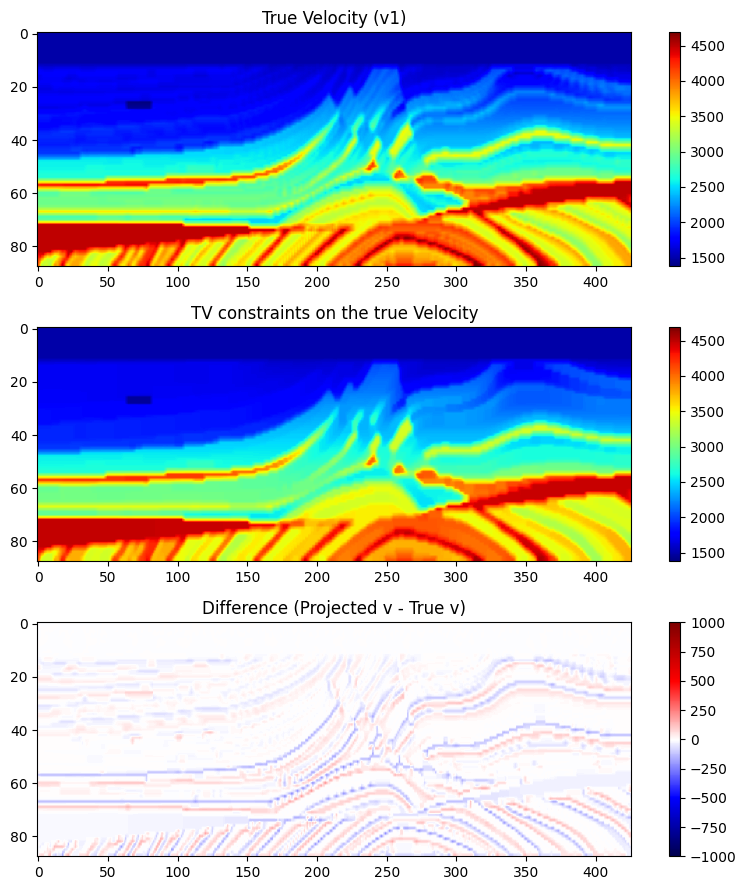

stationary objective and reached feasibility, exiting PARSDMM (iteration 40)


In [13]:
figure(figsize=(8,9))
v1p = reshape(prj(v1), nz, nx)

subplot(3,1,1); imshow(v1,aspect="auto",cmap="jet"); 
colorbar(); clim(vmin,vmax); title("True Velocity (v1)")

subplot(3,1,2); imshow(v1p,aspect="auto",cmap="jet");
colorbar(); clim(vmin,vmax); title("TV constraints on the true Velocity");

subplot(3,1,3); imshow(v1p.-v1,aspect="auto",cmap="seismic");
colorbar(); clim(dmin,dmax); title("Difference (Projected v - True v)");

tight_layout()

## 3. Build a small local compute cluster (2 workers)  <a id='cluster'></a>

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [14]:
nthread = Sys.CPU_THREADS
nw = 2

ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread, nw))" 
addprocs(nw)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, div(nthread, nw)
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, div(nthread, nw)) = (0, 1, 2)
(place1, place2, div(nthread, nw)) = (2, 3, 2)


In [15]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, LinearAlgebra, LineSearches, Optim, Random

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '2'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = ''
      From worker 2:	  OMP_STACKSIZE = '2097152'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPENMP DISPLAY ENVIRONMENT END
      From worker 3:	
      From worker 3:	OPENMP DISPLAY ENVIRONM

## 4. Create list of shot locations <a id='pos'></a>
We use 16 shot locations evenly distributed across the top of the model.

In [16]:
nshots = 16
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)))
@show nshots;
@show sx;

nshots = 16
sx = [0, 1133, 2267, 3400, 4533, 5667, 6800, 7933, 9067, 10200, 11333, 12467, 13600, 14733, 15867, 17000]


## 5. Build `F`, the distributed block operator for seismic modeling <a id='buildF'></a>

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [17]:
@everywhere scratch = "../scratch"
@assert isdir(scratch)

In [18]:
@everywhere begin
    ntrec = 2501
    dtrec = 0.004
    dtmod = 0.002
end

@everywhere function makeF(i,nz,nx,dz,dx,sx)
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,nworkers()),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=0)
end

In [19]:
F = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (88, 426) → (17046816,)"

## 6. Use `F` to create the data in both models <a id='data'></a>

In [20]:
t1 = @elapsed begin
    d1 = F*v1;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

t2 = @elapsed begin
    d2 = F*v2;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in true model; 120.41 seconds
└ @ Main In[20]:4
┌ Info: Time in init model; 103.42 seconds
└ @ Main In[20]:9


#### Compute the residual data

In [21]:
r = d1 .- d2;

## 7. Visualize data <a id='vizD'></a>

#### Collect 3 shots locally before plotting

In [22]:
shots = [1,4,8]
sxlocal = [sx[i] for i in shots]
@show shots
@show sxlocal;

d1local = [getblock(d1,i) for i in shots]
d2local = [getblock(d2,i) for i in shots]
r2local = [getblock(r,i) for i in shots]

shots = [1, 2]
sxlocal = [0, 1133]


2-element Array{Array{Float32,2},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0007449986 0.0009875171 … -0.0009274306 0.000988353; 0.0009028879 0.0009929579 … -0.0016760919 0.00046638865]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.007929874 -0.0049317554 … 0.010042349 0.0074023027; -0.0075787595 -0.00405234 … 0.010118313 0.008520161]

#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below. We flip the direction of the residual and modeled data in order to help display the match with the true data.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
</table>

Note that the data modeled in the initial model lacks a lot of reflectivity that is evident in the data modeled in the true model. We expect to recover this missing reflectivity with the FWI.

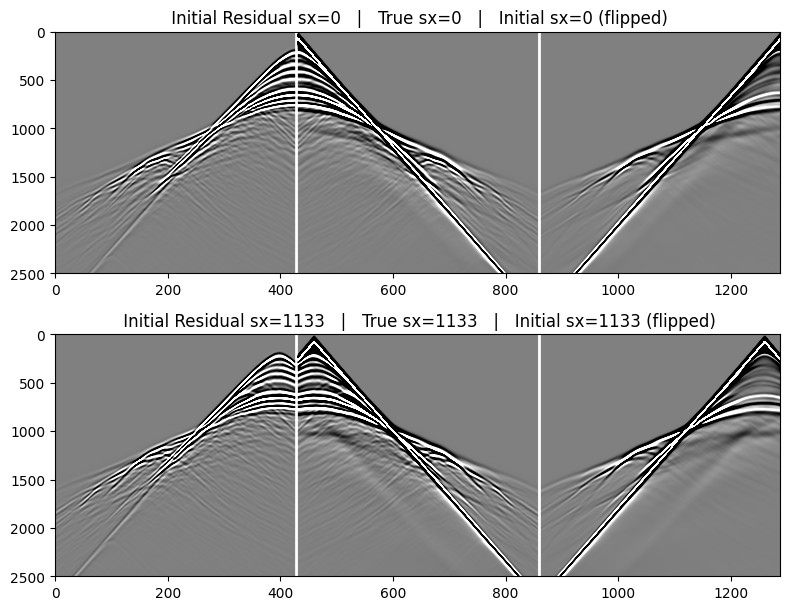

scale = 1.819739453369758


In [23]:
scale = 10.0 / sqrt(norm(d1)^2 / length(d1))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    cat2 = hcat(reverse(r2local[iplot],dims=2), pad, d1local[iplot], pad, reverse(d2local[iplot],dims=2))
    subplot(3,1,iplot);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sx=$(sx[ishot])   |   True sx=$(sx[ishot])   |   Initial sx=$(sx[ishot]) (flipped)");
end
tight_layout()

## 8. Assess if data is cycle skipped at the farthest offsets <a id='cskiped'></a>
Next we plot the far offset traces for these three shots in order to assess if the data is cycle skipped. 

You can ovbserve in the plots below that the refraction waveforms (first arrivals) in the initial model are not cycle skipped with respect to the true model, so we can proceed. 

A very significant part of the residual wavefield is actually reflections in this example.

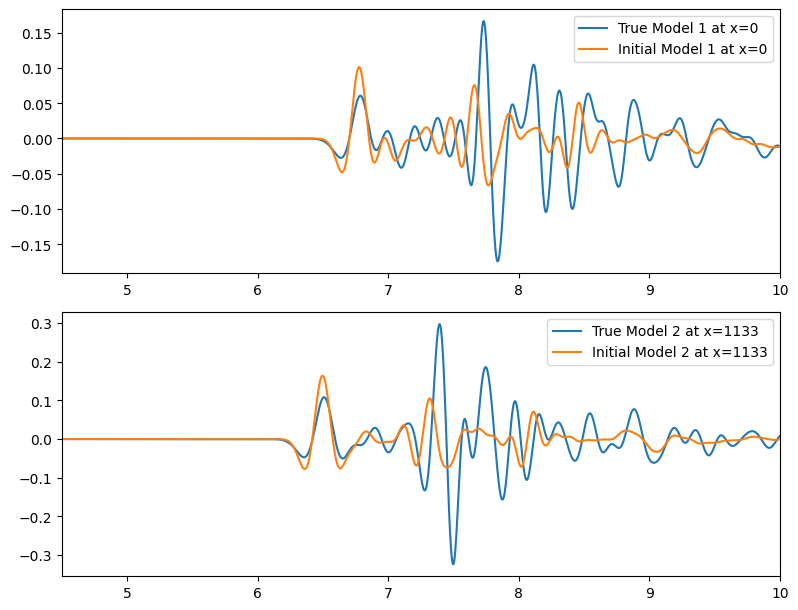

In [24]:
scale = 10.0 / sqrt(norm(d1)^2 / length(d1))
t = [0.0:dtrec:dtrec*(ntrec - 1);]

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    subplot(3,1,iplot);
    plot(t,d1local[iplot][:,end],label="True Model $(ishot) at x=$(sx[ishot])");
    plot(t,d2local[iplot][:,end],label="Initial Model $(ishot) at x=$(sx[ishot])");
    xlim([4.5,t[end]])
    legend()
end
tight_layout()

## 9. Build the `objective`  functions <a id='objective'></a>

#### Build water bottom mask for gradient
We use this mask to remove the imprint in gradients of proximity to source locations. The mask is set to 0 wherever the true velocity model has value 1500 m/s, and is set to 1 otherwise. Without this mask most of the gradient updates would be concentrated close to sources where the model is correct. 

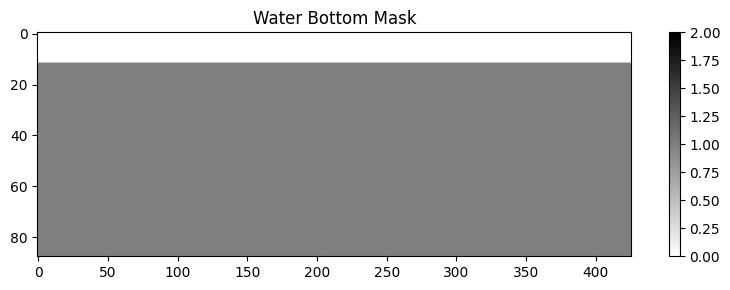

In [25]:
wb_mask = ones(Float32,size(v))
wb_mask[v.==1500.0] .= 0;

figure(figsize=(8,3))
imshow(wb_mask,aspect="auto",cmap="gray_r",clim=[0,+2]);
colorbar();
title("Water Bottom Mask");
tight_layout()

#### Build the `objective` function
This method is called by the solver whenever the gradient is required. Steps in computing the gradient are as follows:
1. Compute the source side illumination `illum`
1. Establish the illumination compensation preconditioner as `illum^-α`
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

In [26]:
function objective(F,v,dobs,wb_mask,p,α)
    v = reshape(v, nz, nx)
    J = jacobian(F,v)
    s = srcillum(J)
    srms = sqrt(norm(s)^2 / length(s))
    s .+= eps(Float32) * srms
    R = JopDiagonal(s.^(-α))
    t = @elapsed begin
        dv = F*v
        G = R' ∘ J' * (dv .- dobs)
    end
    G .*= wb_mask
    ϕ = .5*norm(dv .- dobs)^2
    p.countG += 1
    if p.gscale == 0.0
        # compute scalar from first gradient, apply to future gradients
        p.gscale = 10 ./ maximum(G) 
        @show p.gscale
    end
    G .*= p.gscale
    return ϕ, vec(G)
end

# struct to save the first gradient scalar
mutable struct FwiPar
   countF::Int64
   countG::Int64
   gscale::Float64
end
p = FwiPar(0,0,0.0)
α = 4
g(x) = objective(F,x,d1,wb_mask,p,α)

g (generic function with 1 method)

#### Compute gradient with and without illumination compensation and display

To show the importance of the illumination compensation we will compute two gradients: 
* one with `α = 0` (no illumnation compensation)
* one with `α = 4`

Note how the illumination compensation greatly improved the scaling of the gradient with depth.

In [27]:
tgrad1 = @elapsed begin
    grad1 = reshape(objective(F,v2,d1,wb_mask,p,0.0)[2], nz, nx)
    p.gscale = 0
end
@show tgrad1;

tgrad2 = @elapsed begin
    grad2 = reshape(objective(F,v2,d1,wb_mask,p,4.0)[2], nz, nx)
    p.gscale = 0
end
@show tgrad2;

p.gscale = 0.5045947760011811
tgrad1 = 108.487678621
p.gscale = 1.0778834173185529e22
tgrad2 = 97.51986107


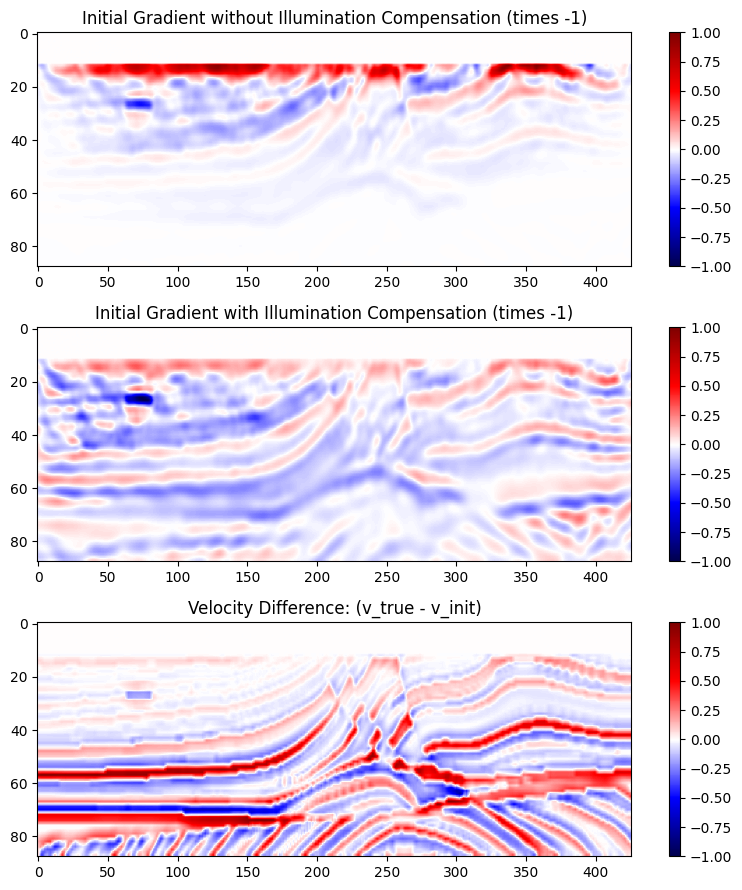

In [28]:
dv = v1 .- v2

figure(figsize=(8,9))

subplot(3,1,1)
imshow(-1 .* grad1 ./ maximum(abs,grad1),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient without Illumination Compensation (times -1)");

subplot(3,1,2)
imshow(-1 .* grad2 ./ maximum(abs,grad2),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient with Illumination Compensation (times -1)");

subplot(3,1,3)
imshow(dv ./ maximum(abs,dv),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Velocity Difference: (v_true - v_init)");

tight_layout()

## 10. Perform the FWI using `minConf_PQN` <a id='inversion'></a>
We will do 25 functions evaluation cost of projected quasi-Newton.

In [29]:
# FWI with PQN
niter = 25
p.gscale = 0.0
options_pqn = pqn_options(progTol=0, store_trace=true, verbose=3, maxIter=niter)

JUDI.SLIM_optim.PQN_params(3, 1.0f-5, 0, 25, 0.0001f0, 10, false, false, true, 1.0f-6, 1.0f-7, 10, false, 20)

In [30]:
sol = minConf_PQN(g, vec(v2), prj, options_pqn);

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 0
Maximum number of SPG iterations: 10
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of function evaluations: 25
input to PARSDMM is feasible, returning
p.gscale = 1.0778834283355252e22
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
input to PARSDMM is feasible, returning
         0          0          0     0.00000e+00     5.47293e+06     1.00000e+01
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
         1          2          4     1.00000e+00     5.28327e+06     9.65283e+00
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARSDMM is feasible, returning
input to PARS

In [31]:
vf = reshape(prj(sol.sol), nz, nx) # optimal solution
ϕ = sol.f_trace   # cost vs iteration
m = sol.x_trace  # model vs iteration
collect(m[i] = reshape(m[i], nz, nx) for i=1:length(ϕ));

input to PARSDMM is feasible, returning


## 11. Visualize velocity models and objective function  <a id='plotres'></a>

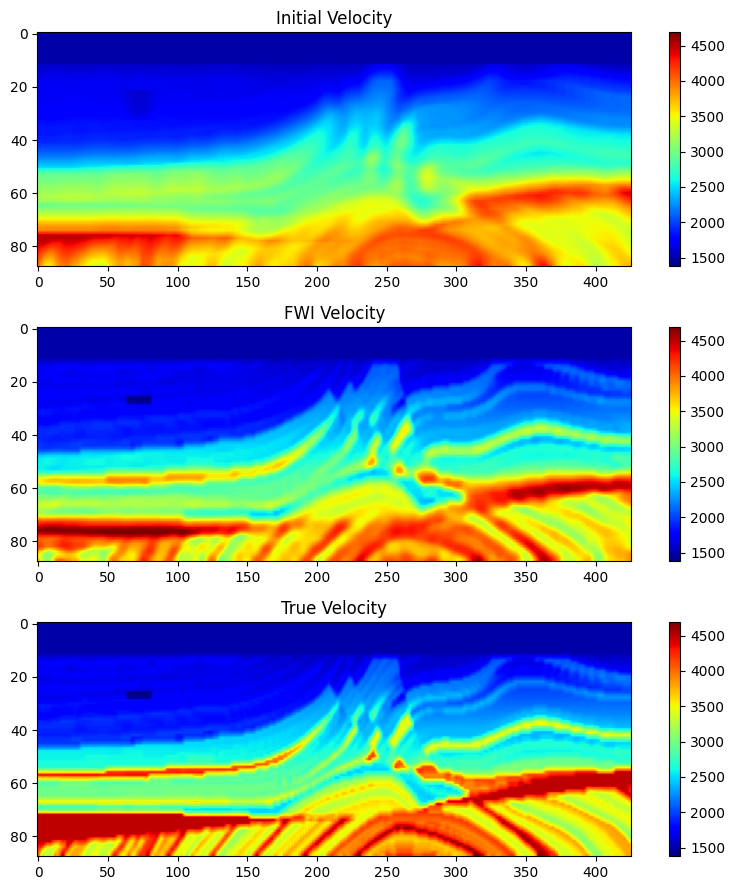

In [32]:
figure(figsize=(8,9)); clf()

subplot(3,1,1);imshow(v2,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial Velocity");

subplot(3,1,2);imshow(vf,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity");

subplot(3,1,3);imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("True Velocity")

tight_layout()

#### Display the velocity difference models 

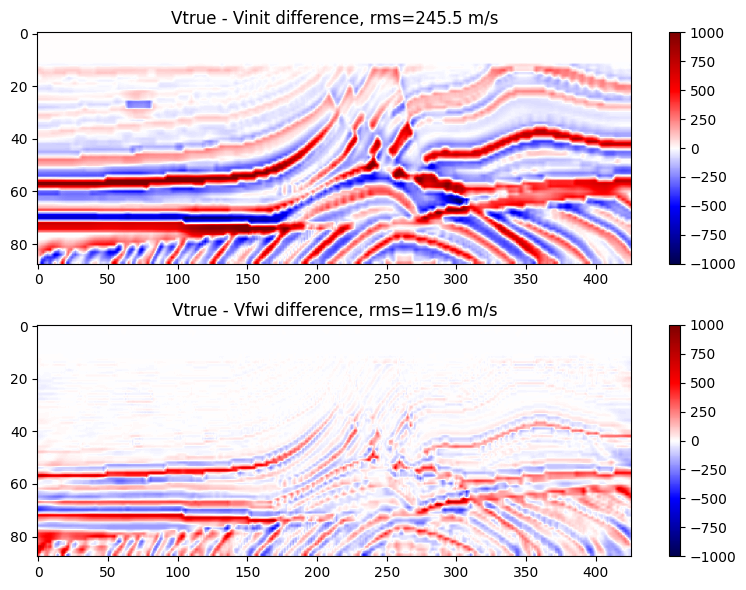

In [33]:
rms_v2 = @sprintf("%.1f m/s", sqrt(norm(v1 .- v2)^2 / length(v1)))
rms_vf = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf)^2 / length(v1)))

figure(figsize=(8,6)); clf()

subplot(2,1,1);imshow(v1 .- v2,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vinit difference, rms=$(rms_v2)");

subplot(2,1,2);imshow(v1 .- vf,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vfwi difference, rms=$(rms_vf)");

tight_layout()

#### Display the cost function 

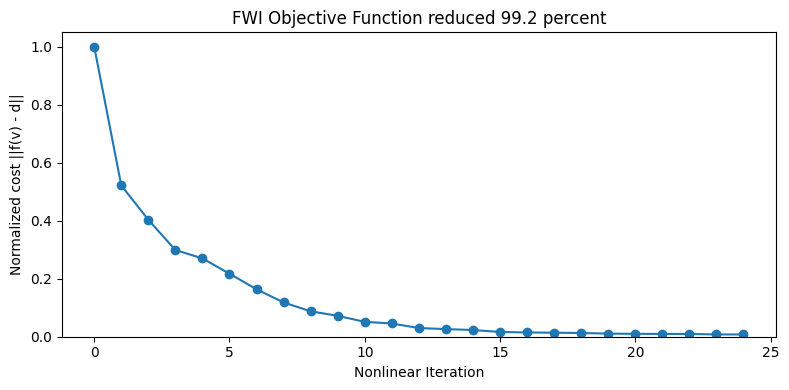

In [34]:
figure(figsize=(8,4)); clf()
iters = [0:1:niter;]
plot(ϕ[2:end] ./ ϕ[2], marker="o")
ylim([0,1.05])
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title(@sprintf("FWI Objective Function reduced %.1f percent", 100 * (ϕ[2] - ϕ[end]) / ϕ[2]));
tight_layout()

#### Display data misfit vs model misfit

In [35]:
size(ϕ), size(m)

((26,), (26,))

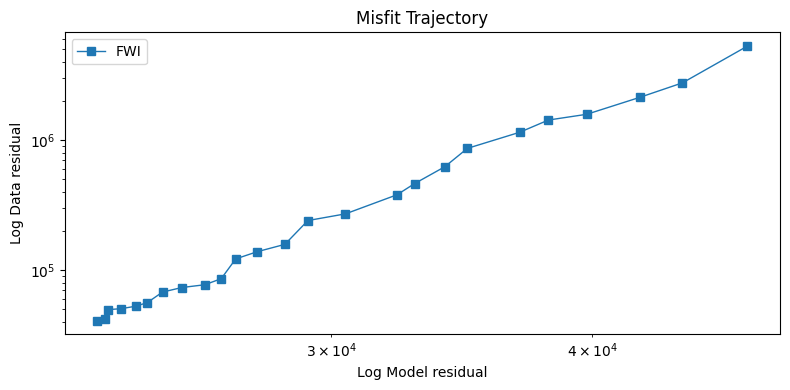

In [36]:
figure(figsize=(8,4)); clf()

c = [norm(m[i] .- v1, 2) for i in 1:length(m)]
loglog(c[2:end], ϕ[2:end], label="FWI", marker="s", linewidth=1)
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory");
tight_layout()

## 12. Visualize data match <a id='matchD'></a>
#### Generate data in the FWI velocity model

In [37]:
tf = @elapsed begin
    df = F*vf;
end
@show tf;

tf = 9.404564716


#### Compute residuals and collect gathers for display

In [38]:
rf = d1 .- df;
dflocal = [getblock(df,i) for i in shots];
rflocal = [getblock(rf,i) for i in shots];

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We will flip the direction of the residual and modeled data in order to help display the match with the true data. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Data<br>(flipped)</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [39]:
function make_plot(index)
    figure(figsize=(8,6)); clf()
    cat2 = hcat(reverse(r2local[index],dims=2), pad, d1local[index], pad, reverse(d2local[index],dims=2))
    catf = hcat(reverse(rflocal[index],dims=2), pad, d1local[index], pad, reverse(dflocal[index],dims=2))
    subplot(2,1,1);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sx=$(sx[index])   ||   True sx=$(sx[index])   ||   Initial sx=$(sx[index]) (flipped)");
    subplot(2,1,2);
    imshow(catf,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" FWI Residual sx=$(sx[index])   ||   True sx=$(sx[index])   ||   FWI sx=$(sx[index]) (flipped)");
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

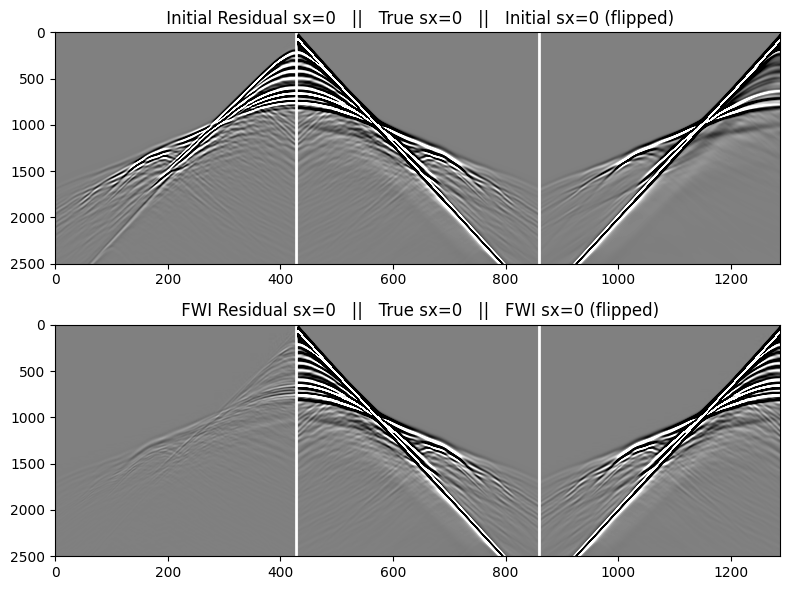

In [40]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

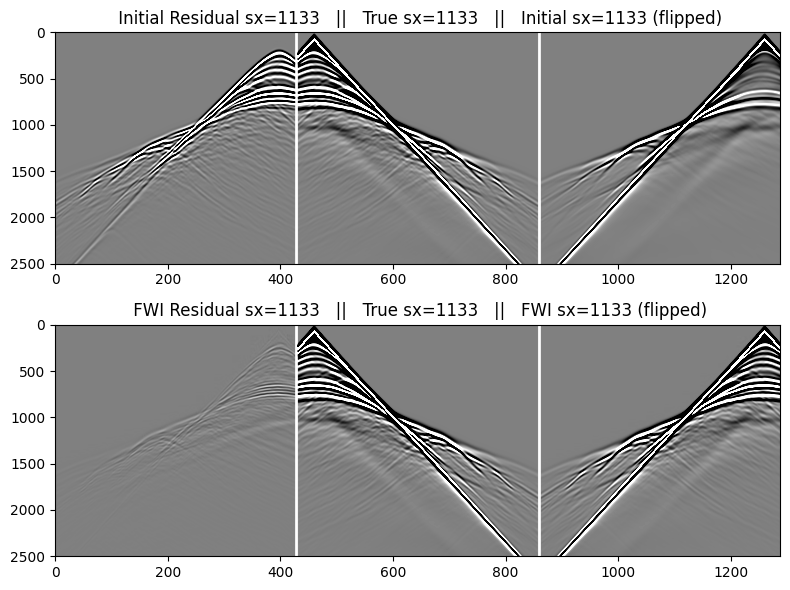

In [41]:
make_plot(2)

#### Data for the 8th shot, generated in the initial and FWI models

In [42]:
make_plot(3)

LoadError: BoundsError: attempt to access 2-element Array{Array{Float32,2},1} at index [3]

## 13. Write models to local disk <a id='writeres'></a>

#### Interpolate models to 10m for subsequent RTM  

In [43]:
@printf("nz,nx,dz,dx; %5d %5d %12.4f %12.4f\n", nz, nx, dz, dx)

z1,z2 = 0.0,dz*(nz-1)
x1,x2 = 0.0,dx*(nx-1)

dz2,dx2 = 10.0,10.0
nz2 = floor(Int,z2/dz2) + 1
nx2 = floor(Int,x2/dx2) + 1

dom = JetSpace(Float32,size(vf)...)
rng = JetSpace(Float32,nz2,nx2)
op = JopInterp(dom, rng)

v1_resamp = op * v1;
v2_resamp = op * v2;
vf_resamp = op * vf;

nz,nx,dz,dx;    88   426      40.0000      40.0000


#### Plot the resampled models

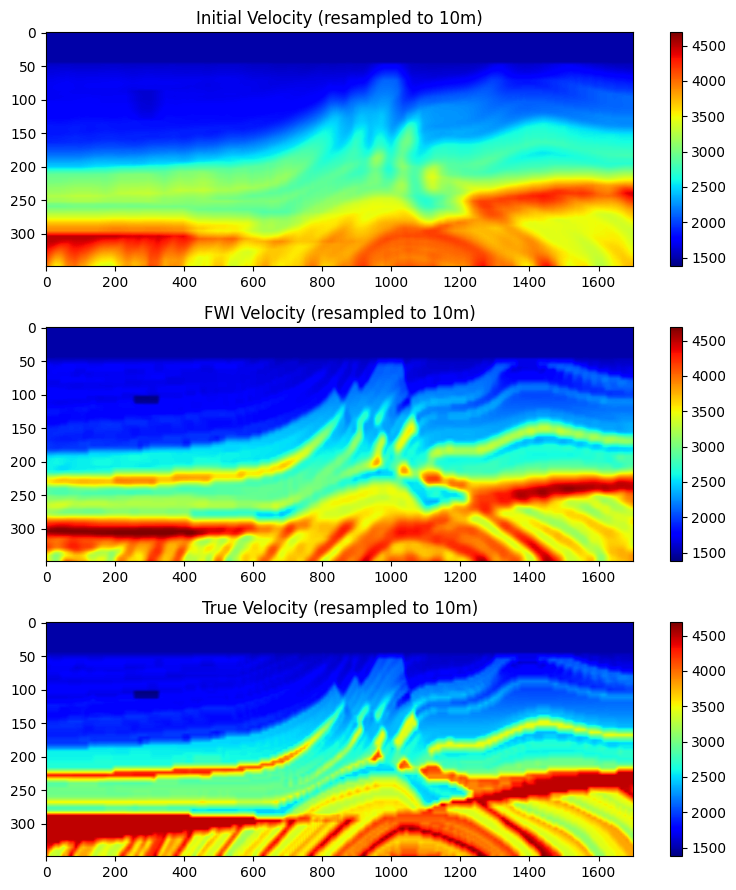

In [44]:
figure(figsize=(8,9)); clf()

subplot(3,1,1);imshow(v2_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("Initial Velocity (resampled to 10m)");

subplot(3,1,2);imshow(vf_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("FWI Velocity (resampled to 10m)");

subplot(3,1,3);imshow(v1_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity (resampled to 10m)")

tight_layout()

#### Write out the models 

In [45]:
file1 = @sprintf("SLIM_marmousi_resampled_10m_%dx%d_vtrue.bin", nz2, nx2);
file2 = @sprintf("SLIM_marmousi_resampled_10m_%dx%d_vinit.bin", nz2, nx2);
filef = @sprintf("SLIM_marmousi_resampled_10m_%dx%d_vfwi.bin", nz2, nx2);

write(file1,v1_resamp);
write(file2,v2_resamp);
write(filef,vf_resamp);

## 14. Remove local files and workers <a id='del'></a>

In [46]:
close(F);
rmprocs(workers());

## Record time at end of notebook
Report total elapsed time to run the notebook

In [47]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 102.49 minutes\n"